# Science Demonstration Case: Polar Science
# Automatic ice damage detection from Sentinel-1 radar imagery
## Step 3: Train the U-Net neural network.
### For more info about this science case, please check the documentation [at this link](https://earthsystemdatalab.net/science_cases/polar_science/).

This notebook shows how to train a Neural Network in order to infer the ice damage from Sentinel-1 imagery.<br>
The ice damage is an key variable when modeling the mass loss of the Antarctic Ice Sheet, as the presence or absence of crevasses and fractures influences the resistance of the ice to the natural gravitational flow into the ocean, that the rising temperatures of the current climate crisis are enhancing.
<br>
The datacube used in this notebook contains Sentinel-1 imagery over the Amery Ice Shelf (East Antarctica) and a model of the ice damage over the same area.
<br>
The notebook employs a modified U-Net Convolutional Neural Network and it is largely based on [this Tensorflow tutorial](https://www.tensorflow.org/tutorials/images/segmentation).

**This notebook runs with the python environment `users-science-case-polar`, please checkout the documentation for [help on changing the environment](https://deepesdl.readthedocs.io/en/latest/guide/jupyterlab/#python-environment-selection-of-the-jupyter-kerne).**



<b>Bibliography</b>
- Recognising ice damage from satellite imagery: [Lhermitte et al. (2020)](https://www.pnas.org/doi/abs/10.1073/pnas.1912890117) & [Lai et al. (2020)](https://www.nature.com/articles/s41586-020-2627-8)
- U-Net: [Ronneberger et al. (2015)](https://arxiv.org/abs/1505.04597)
- MobileNetV2 encoder: [Sandler et al. (2018)](https://arxiv.org/abs/1801.04381)
- pix2pix cGAN: [Isola et al. (2017)](https://arxiv.org/abs/1611.07004)

<span style="font-size:15pt;">Before you can run this notebook you need to install tensorflow_examples from GitHub: <br>
    https://github.com/tensorflow/examples.git upon first time with the following line and **restart the kernel**. <br>
    Once done, comment the line to not run it again. </span>



In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

In [ ]:
import os
import zipfile
from pathlib import Path

import gdown
import numpy as np
import tensorflow as tf
import xarray as xr
from IPython.display import clear_output
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow_examples.models.pix2pix import pix2pix
from xcube.core.store import new_data_store

Define the parameters needed to access the S3 storage. They are saved as environment variables.

In [2]:
S3_USER_STORAGE_KEY = os.environ["S3_USER_STORAGE_KEY"]
S3_USER_STORAGE_SECRET = os.environ["S3_USER_STORAGE_SECRET"]
S3_USER_STORAGE_BUCKET = os.environ["S3_USER_STORAGE_BUCKET"]

team_store = new_data_store(
    data_store_id="s3",
    root=S3_USER_STORAGE_BUCKET,
    storage_options=dict(
        anon=False, key=S3_USER_STORAGE_KEY,
        secret=S3_USER_STORAGE_SECRET
    )
)

In [9]:
S3_USER_STORAGE_KEY = os.environ["S3_USER_STORAGE_KEY"]
S3_USER_STORAGE_SECRET = os.environ["S3_USER_STORAGE_SECRET"]
S3_USER_STORAGE_BUCKET = os.environ["S3_USER_STORAGE_BUCKET"]

public_store = new_data_store(
    data_store_id="s3",
    root="deep-esdl-public/science-cases/polar-science",
    max_depth=2,
    storage_options=dict(
        anon=False, key=S3_USER_STORAGE_KEY,
        secret=S3_USER_STORAGE_SECRET
    )
)

Define a plotting function to quickly show the Sentinel-1 imagery, the true ice damage model and the predicted damage model inferred by the neural network.

In [3]:
def show_imagery_and_damage(tiles_list: list[np.ndarray]) -> None:
    """
    Create a figure to show imagery and damage model next to each other.
    
    Parameters
    ----------
    tiles_list : list[np.ndarray]
        A list containing a number of arrays, maximum three: the Sentinel-1 imagery, the true damage model and the damage model predicted by the NN.
    """
    title_list = ["Input S1 imagery", "Input damage mask", "Predicted damage mask"]
    cmap_list = ["Greys_r", "viridis", "viridis"]
    _, axs = plt.subplots(ncols=len(tiles_list), figsize=(15, 15))
    for i in range(len(tiles_list)):
        ax = axs[i]
        ax.imshow(tiles_list[i][:, :, 0], cmap=cmap_list[i], vmin=0, vmax=2)
        ax.set_title(title_list[i])
        ax.set_axis_off()
    plt.show()

Define the directories where to save the plots and the trained neural networks.

In [4]:
plot_dir = Path.cwd() / "plots"
plot_dir.mkdir(exist_ok=True)
trained_nn_dir = Path.cwd() / "trained_nn"
trained_nn_dir.mkdir(exist_ok=True)

# Prepare the input data

Load the data cube, containing the Sentinel-1 imagery, the ice damage mask and the grounded ice  (ice sheet) and ocean masks.

Note that the step2 Jupyter Notebook retrieves only the imagery for a very narrow time window (5 days in October 2015), to provide with an illustrative example without consuming excessive computational resources. During the development of this use case, however, four larger datacubes were prepared, containing all the Sentinel-1 imagery data available during Q4 (Oct-Dec) of 2015 and 2016.

In this example we mix data acquired during ascending and descending orbits. A potential straightforward expansion of this work would be to train the NN over the two datasets separately, to investigate whether there is a difference in performance depending on the orbit type.

In [10]:
iceshelf_name = "amery"
polarization_mode = "SH"
polarization_type = "HH"

masks_storage_path = f"datacubes/{iceshelf_name}/damage_models_res_500m.zarr"
masks_xr = team_store.open_data(masks_storage_path)
masks_xr = masks_xr.reindex(x=masks_xr.x[::-1])

orbit_type = "ascending"
time_period = "2015_Q4"
imagery_ascending_2015Q4_storage_path = f"{iceshelf_name}/s1_imagery_res_500m_{polarization_mode}_{polarization_type}_{orbit_type.capitalize()}_{time_period}.zarr"
imagery_ascending_2015Q4_xr = public_store.open_data(imagery_ascending_2015Q4_storage_path)
imagery_ascending_2015Q4_xr = imagery_ascending_2015Q4_xr.reindex(x=imagery_ascending_2015Q4_xr.x[::-1])

orbit_type = "descending"
time_period = "2015_Q4"
imagery_descending_2015Q4_storage_path = f"{iceshelf_name}/s1_imagery_res_500m_{polarization_mode}_{polarization_type}_{orbit_type.capitalize()}_{time_period}.zarr"
imagery_descending_2015Q4_xr = public_store.open_data(imagery_descending_2015Q4_storage_path)
imagery_descending_2015Q4_xr = imagery_descending_2015Q4_xr.reindex(x=imagery_descending_2015Q4_xr.x[::-1])

orbit_type = "ascending"
time_period = "2016_Q4"
imagery_ascending_2016Q4_storage_path = f"{iceshelf_name}/s1_imagery_res_500m_{polarization_mode}_{polarization_type}_{orbit_type.capitalize()}_{time_period}.zarr"
imagery_ascending_2016Q4_xr = public_store.open_data(imagery_ascending_2016Q4_storage_path)
imagery_ascending_2016Q4_xr = imagery_ascending_2016Q4_xr.reindex(x=imagery_ascending_2016Q4_xr.x[::-1])

orbit_type = "descending"
time_period = "2016_Q4"
imagery_descending_2016Q4_storage_path = f"{iceshelf_name}/s1_imagery_res_500m_{polarization_mode}_{polarization_type}_{orbit_type.capitalize()}_{time_period}.zarr"
imagery_descending_2016Q4_xr = public_store.open_data(imagery_descending_2016Q4_storage_path)
imagery_descending_2016Q4_xr = imagery_descending_2016Q4_xr.reindex(x=imagery_descending_2016Q4_xr.x[::-1])

Tile the data and keep only the ones within the ice shelf.

In [11]:
def tile_array(data_xr: xr.DataArray, tile_size: int):
    num_tiles_along_y = data_xr.sizes["y"] // tile_size
    num_tiles_along_x = data_xr.sizes["x"] // tile_size
    num_times = data_xr.sizes["time"]

    data_array = data_xr.isel(
        x=slice(num_tiles_along_x * tile_size),
        y=slice(num_tiles_along_y * tile_size)
    ).to_numpy()
    tiled_data_array = data_array.reshape(
        num_times, num_tiles_along_y, tile_size, num_tiles_along_x, tile_size
    ).swapaxes(2, 3)
    return tiled_data_array

In [12]:
def select_tiles_to_use(
    imagery: np.ndarray,
    damage_mask: np.ndarray,
    ocean_mask: np.ndarray,
    grounded_ice_mask: np.ndarray) -> np.ndarray:

    num_scenes = imagery.shape[0]
    bool_full_tiles_imagery = np.invert(np.isnan(imagery).any(axis=4).any(axis=3))
    bool_tiles_overlapping_ice_shelf = damage_mask.sum(axis=4).sum(axis=3).astype(bool)
    bool_tiles_overlapping_ice_shelf = np.repeat(
        bool_tiles_overlapping_ice_shelf, num_scenes, axis=0)
    bool_combined = bool_tiles_overlapping_ice_shelf & bool_full_tiles_imagery

    filtered_imagery = imagery[bool_combined]
    filtered_damage_mask = np.repeat(damage_mask, num_scenes, axis=0)[bool_combined]
    filtered_ocean_mask = np.repeat(ocean_mask, num_scenes, axis=0)[bool_combined]
    filtered_grounded_ice_mask = np.repeat(grounded_ice_mask, num_scenes, axis=0)[bool_combined]

    return np.stack((
        filtered_imagery, filtered_ocean_mask,
        filtered_grounded_ice_mask, filtered_damage_mask),
        axis=0)

In [13]:
# NB: this step can take up to a few minutes to complete

tile_size = 128
tiled_damage_mask_surface_temp = tile_array(masks_xr.damage_class_surface_temp, tile_size)
tiled_damage_mask_depth_temp = tile_array(masks_xr.damage_class_depth_temp, tile_size)
tiled_damage_mask_uniform_temp = tile_array(masks_xr.damage_class_uniform_temp, tile_size)
tiled_ocean_mask = tile_array(masks_xr.ocean_mask, tile_size)
tiled_grounded_ice_mask = tile_array(masks_xr.grounded_ice_mask, tile_size)
tiled_imagery_ascending_2015Q4 = tile_array(imagery_ascending_2015Q4_xr.s1_imagery, tile_size)
tiled_imagery_descending_2015Q4 = tile_array(imagery_descending_2015Q4_xr.s1_imagery, tile_size)
tiled_imagery_ascending_2016Q4 = tile_array(imagery_ascending_2016Q4_xr.s1_imagery, tile_size)
tiled_imagery_descending_2016Q4 = tile_array(imagery_descending_2016Q4_xr.s1_imagery, tile_size)

For this example we use the damage model obtained by assuming a constant vertical temperature gradient between the visible surface and the bottom of the ice shelf - the _depth_temp_ mask.

In [14]:
filtered_data_ascending_2015Q4 = select_tiles_to_use(
    tiled_imagery_ascending_2015Q4,
    tiled_damage_mask_depth_temp,
    tiled_ocean_mask,
    tiled_grounded_ice_mask)
filtered_data_descending_2015Q4 = select_tiles_to_use(
    tiled_imagery_descending_2015Q4,
    tiled_damage_mask_depth_temp,
    tiled_ocean_mask,
    tiled_grounded_ice_mask)
filtered_data_ascending_2016Q4 = select_tiles_to_use(
    tiled_imagery_ascending_2016Q4,
    tiled_damage_mask_depth_temp,
    tiled_ocean_mask,
    tiled_grounded_ice_mask)
filtered_data_descending_2016Q4 = select_tiles_to_use(
    tiled_imagery_descending_2016Q4,
    tiled_damage_mask_depth_temp,
    tiled_ocean_mask,
    tiled_grounded_ice_mask)

Stack imagery and ocean / grounded ice masks together, to create the input with three channels.

In [15]:
all_data = np.concatenate((
    filtered_data_ascending_2015Q4, filtered_data_descending_2015Q4,
    filtered_data_ascending_2016Q4, filtered_data_descending_2016Q4),
    axis=1
)

input_data = all_data[:3]
input_data = np.swapaxes(input_data, 0, 1)
input_data = np.swapaxes(input_data, 1, 3)

damage_model = all_data[3].astype(np.int8)
damage_model = np.expand_dims(damage_model, axis=0)
damage_model = np.swapaxes(damage_model, 0, 1)
damage_model = np.swapaxes(damage_model, 1, 3)

In [16]:
print(input_data.shape)
print(damage_model.shape)

(1429, 128, 128, 3)
(1429, 128, 128, 1)


Let's have a look at how these tiles look like. Let's plot the three datasets passed as input data (imagery and binary masks) and the corresponding damage model.

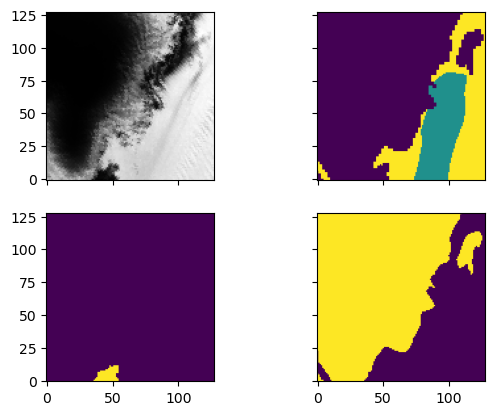

In [17]:
index = 510
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
axes[0, 0].imshow(input_data[index, :, :, 0], origin="lower", cmap="Greys_r")
axes[0, 1].imshow(damage_model[index], origin="lower", cmap="viridis")
axes[1, 0].imshow(input_data[index, :, :, 1], origin="lower", cmap="viridis")
axes[1, 1].imshow(input_data[index, :, :, 2], origin="lower", cmap="viridis")

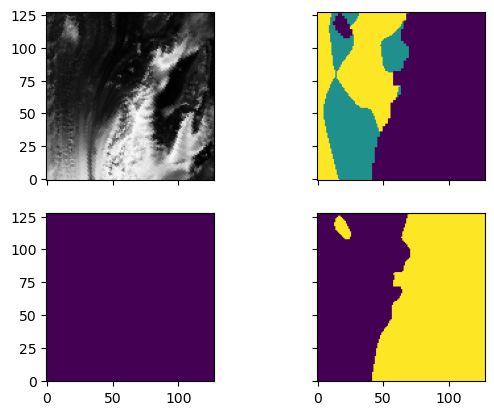

In [18]:
index = 130
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True)
axes[0, 0].imshow(input_data[index, :, :, 0], origin="lower", cmap="Greys_r")
axes[0, 1].imshow(damage_model[index], origin="lower", cmap="viridis")
axes[1, 0].imshow(input_data[index, :, :, 1], origin="lower", cmap="viridis")
axes[1, 1].imshow(input_data[index, :, :, 2], origin="lower", cmap="viridis")

Split data between training and testing.

In [19]:
np.random.seed(1)    # for reproducibility

number_tiles = input_data.shape[0]
percentage_split_for_training = 0.8
boolean_split_train_test = np.random.rand(number_tiles) < percentage_split_for_training

train_input_data = input_data[boolean_split_train_test]
train_damage_model = damage_model[boolean_split_train_test]
test_input_data = input_data[np.invert(boolean_split_train_test)]
test_damage_model = damage_model[np.invert(boolean_split_train_test)]

Convert the data into tensorflow format.

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input_data, train_damage_model))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input_data, test_damage_model))

2025-11-21 09:51:51.873843: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-11-21 09:51:51.874789: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 223936512 exceeds 10% of free system memory.


# Input pipeline

Define the data augmentation: reduce overfitting and, in general, improve the performance of the CNN by flipping/deforming the original tiles.


In [21]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they"ll make the same random changes
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

Set the parameters for training.
<br>
- ```TRAIN_LENGTH``` is the number of tiles used for the training.
- ```BATCH_SIZE``` is the number of tiles used in each batch: when ```TRAIN_LENGTH``` is very high, or the images are very large, the batch needs to set as a fraction of the total training length (e.g. 1/4).
- ```BUFFER_SIZE``` sets the extent to which that training data is shuffled between epochs and should be at least equal to ```TRAIN_LENGTH```.
- ```STEPS_PER_EPOCH``` is the number of steps needed to pass over the entire training dataset, given ```BATCH_SIZE```.

In [22]:
TRAIN_LENGTH = boolean_split_train_test.sum()
BATCH_SIZE = TRAIN_LENGTH // 3
BUFFER_SIZE = boolean_split_train_test.sum() * 2
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

Combine everything together to set the input pipeline.

In [23]:
train_batches = (
    train_dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_dataset.batch(BATCH_SIZE)

2025-11-21 09:52:06.456964: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 223936512 exceeds 10% of free system memory.


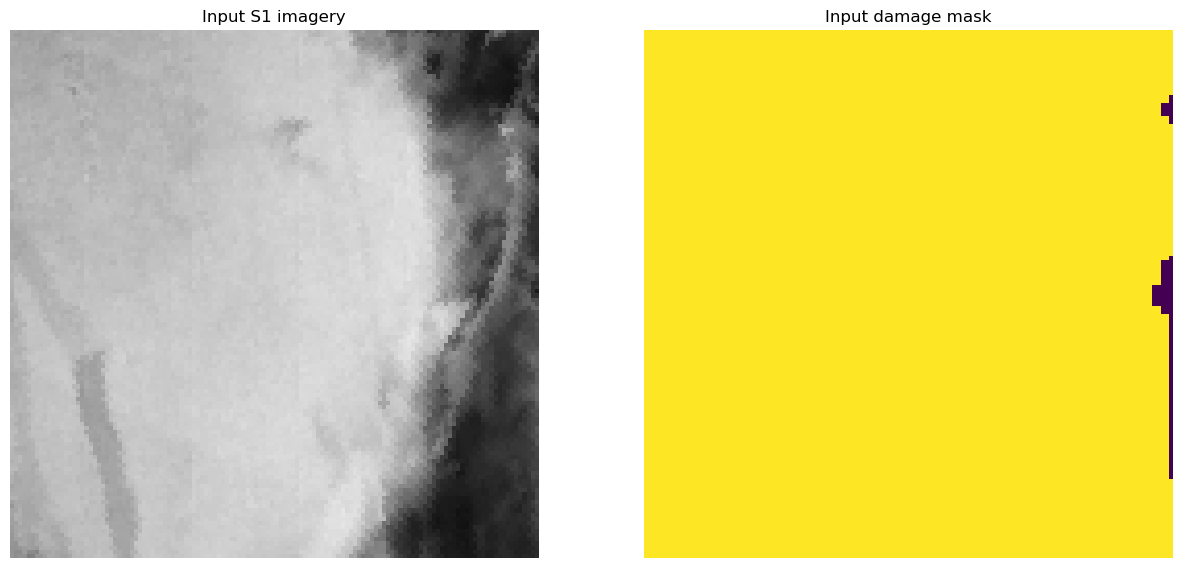

2025-11-21 09:52:06.933934: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [24]:
for images, masks in train_batches.take(1):
    sample_image, sample_mask = images[0], masks[0]
    display_list = [sample_image, sample_mask]
    show_imagery_and_damage(display_list)

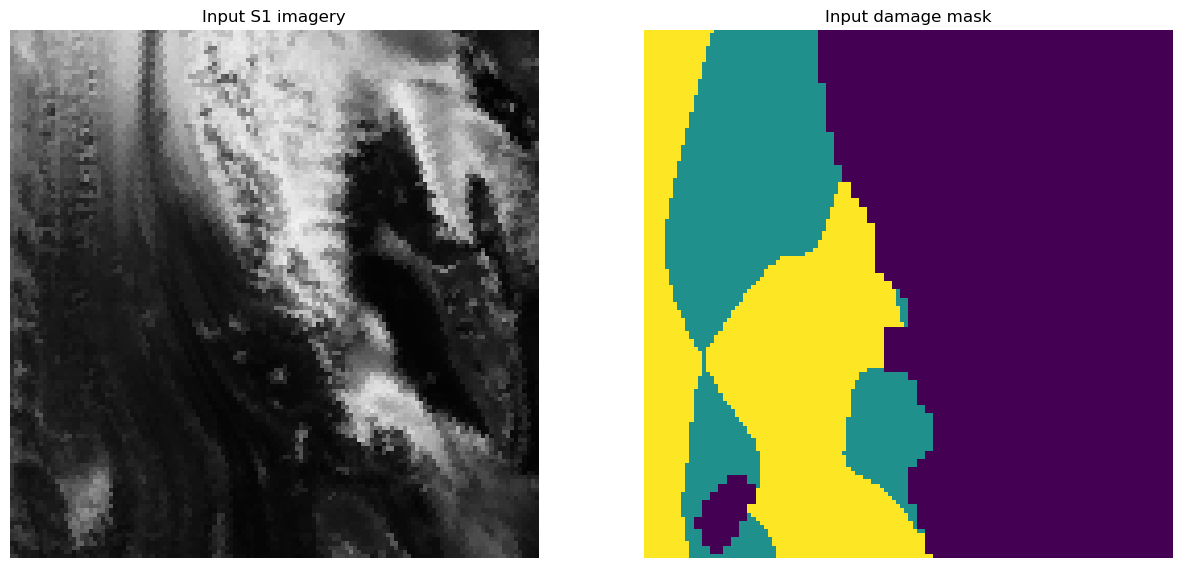

2025-11-21 09:52:07.997020: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [25]:
for images, masks in test_batches.take(1):
    sample_image, sample_mask = images[3], masks[3]
    display_list = [sample_image, sample_mask]
    show_imagery_and_damage(display_list)

2025-11-21 09:52:08.672616: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 223936512 exceeds 10% of free system memory.


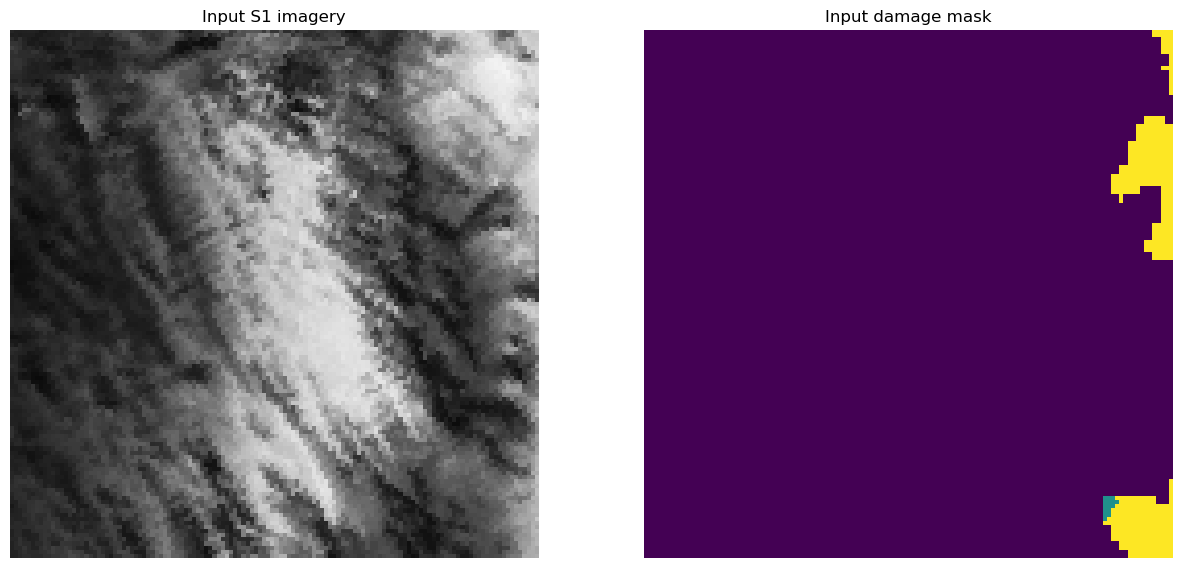

In [26]:
for images, masks in train_batches.take(1):
    sample_image, sample_mask = images[0], masks[0]
    display_list = [sample_image, sample_mask]
    show_imagery_and_damage(display_list)

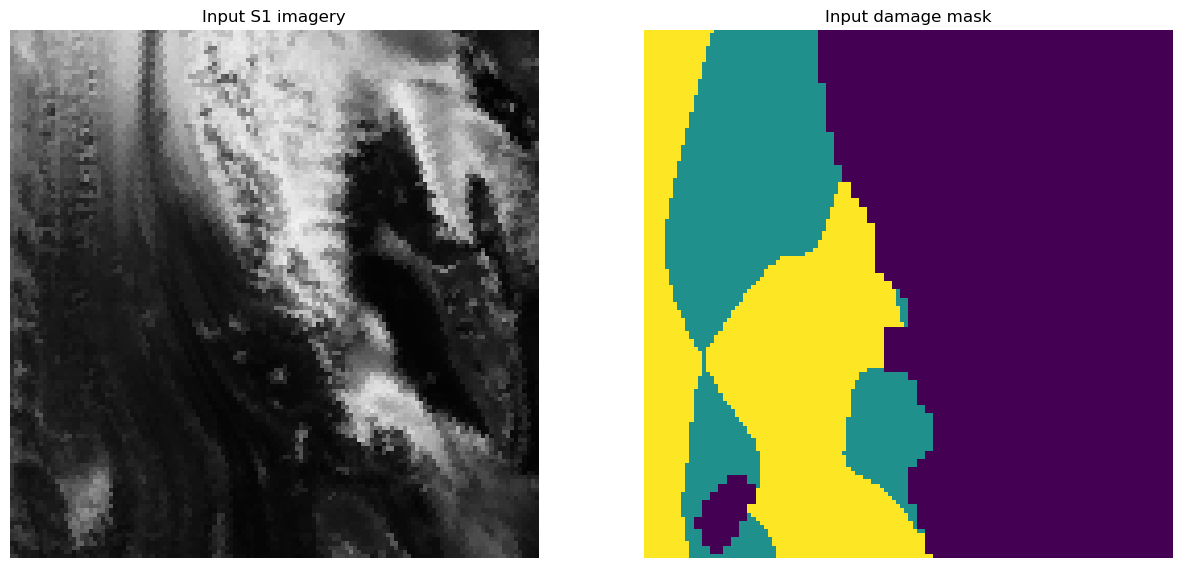

2025-11-21 09:52:09.411188: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [27]:
for images, masks in test_batches.take(1):
    sample_image, sample_mask = images[3], masks[3]
    display_list = [sample_image, sample_mask]
    show_imagery_and_damage(display_list)

2025-11-21 09:52:09.966735: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 223936512 exceeds 10% of free system memory.


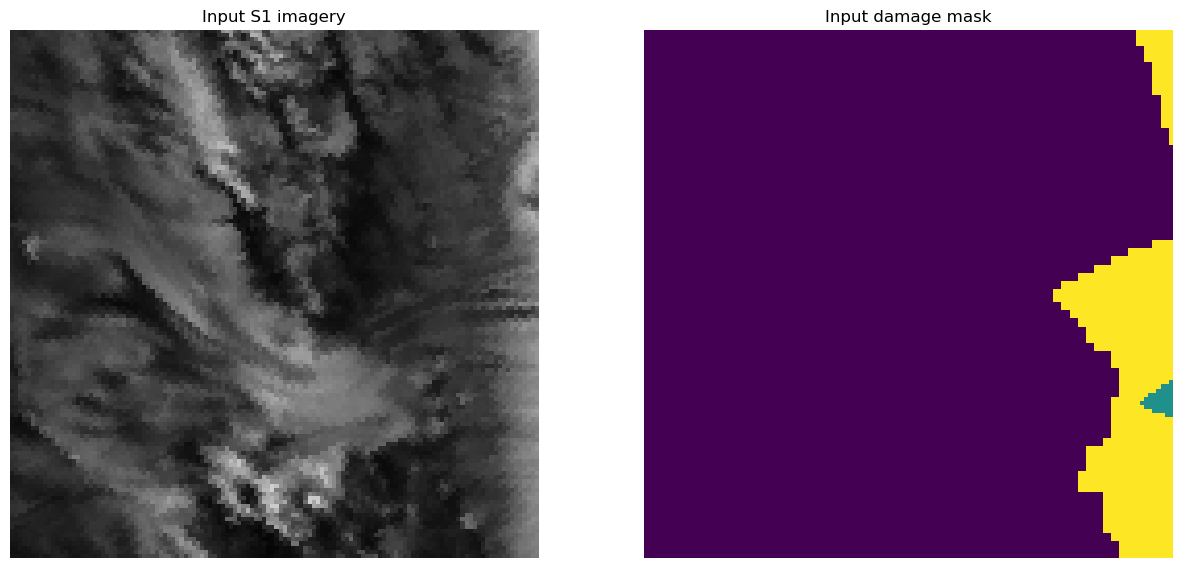

In [28]:
for images, masks in train_batches.take(1):
    sample_image, sample_mask = images[0], masks[0]
    display_list = [sample_image, sample_mask]
    show_imagery_and_damage(display_list)

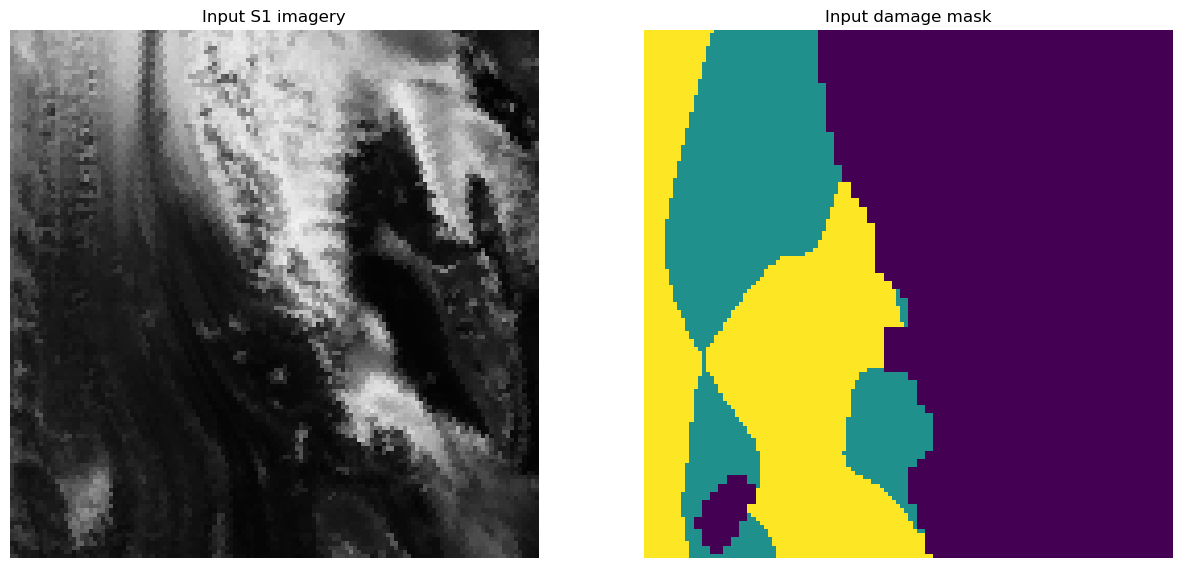

In [29]:
for images, masks in test_batches.take(1):
    sample_image, sample_mask = images[3], masks[3]
    display_list = [sample_image, sample_mask]
    show_imagery_and_damage(display_list)

# Define the model

The encoder (downsampler) uses a pretrained MobileNetV2 model to reduce the number of trainable parameters. In particular, the activations of some intermediate layers are employed. See [Sandler et al. (2018)](https://arxiv.org/abs/1801.04381) for more information.

In [30]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=[128, 128, 3],
    include_top=False)

layer_names = [
    "block_1_expand_relu",   # 64x64
    "block_3_expand_relu",   # 32x32
    "block_6_expand_relu",   # 16x16
    "block_13_expand_relu",  # 8x8
    "block_16_project",      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(
    inputs=base_model.input,
    outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


The decoder (upsampler) uses the blocks already implemented in the pix2pix Tensorflow example. See [Isola et al. (2017)](https://arxiv.org/abs/1611.07004) for further information.

In [31]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

The two parts are combined together into the final U-Net model.

In [32]:
def unet_model(output_channels: int):
    inputs = tf.keras.layers.Input(shape=[128, 128, output_channels])

    # downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # upsampling
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding="same")  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

Set the final parameters and compile the model.
<br>
```OUTPUT_CLASSES``` represents the number of classes in the damage mask, currently three: (0) outside the ice-shelf, (1) damaged ice, (2) intact ice.

In [33]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer="adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

Visualise the model architecture.

In [34]:
path_to_model_scheme_plot = plot_dir / "unet_model_128x128.png"
tf.keras.utils.plot_model(
    model, show_shapes=True, expand_nested=False,
    to_file=path_to_model_scheme_plot)

You must install pydot (`pip install pydot`) for `plot_model` to work.


# Train the model

Functions that show the learning progress, while the model is being trained.

In [35]:
# determine predicted damage mask
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

# display predicted mask
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            show_imagery_and_damage([image[0], mask[0], create_mask(pred_mask)])
    else:
        show_imagery_and_damage([
            sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step


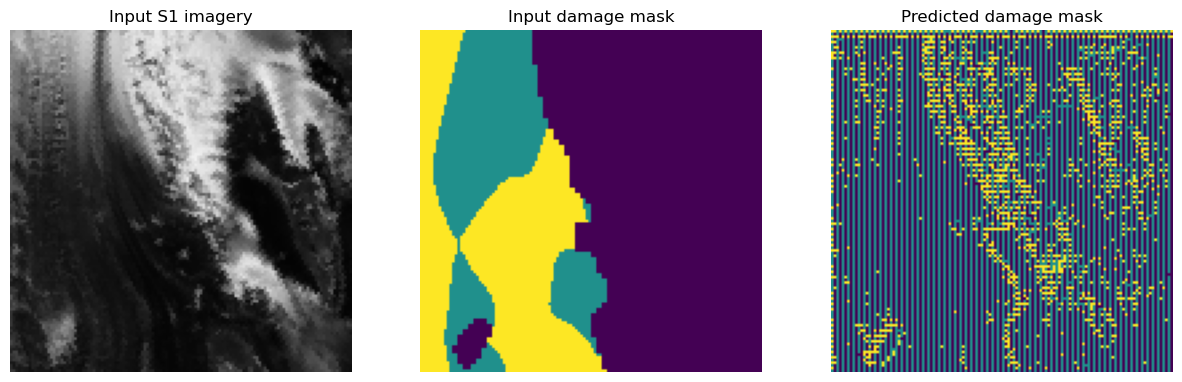

In [36]:
# this is before starting any model training
show_predictions()

In [37]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ("\nSample Prediction after epoch {}\n".format(epoch+1))

Run the training.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


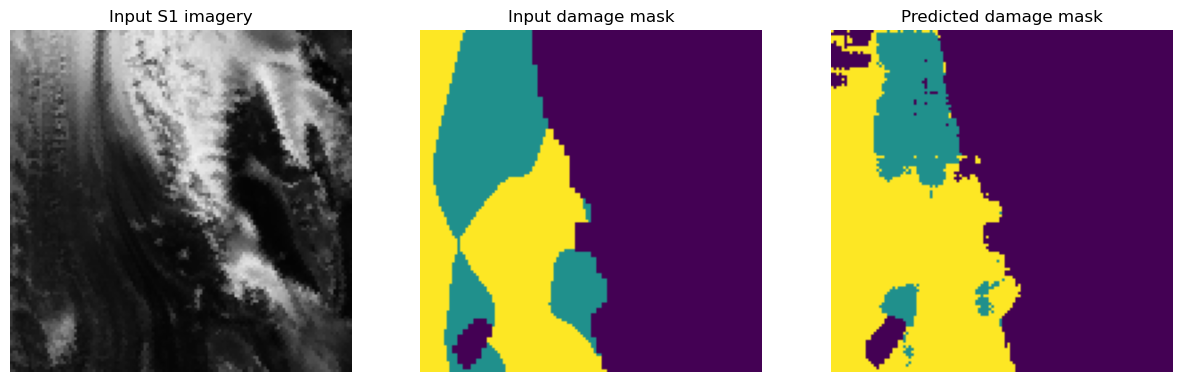


Sample Prediction after epoch 100

3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 8s/step - accuracy: 0.9611 - loss: 0.1141 - val_accuracy: 0.9311 - val_loss: 0.2062


In [38]:
EPOCHS = 100    # (currently no further improvements after 100 epochs)
VAL_SUBSPLITS = 1
# VALIDATION_STEPS = 23//BATCH_SIZE//VAL_SUBSPLITS
VALIDATION_STEPS = 1

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

### Plot the learning curves of the model

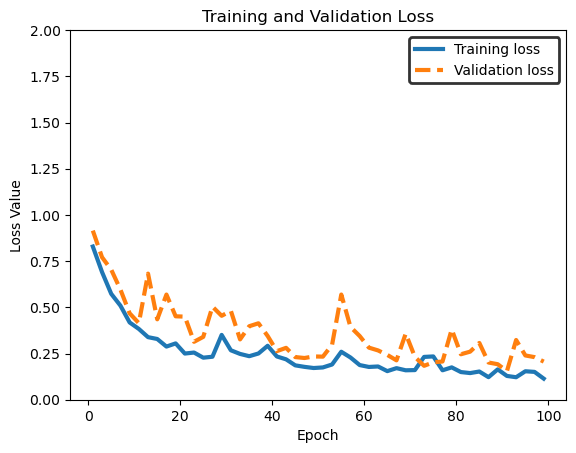

In [39]:
epoch_array = np.array(model_history.epoch)[1::2]
loss_array = np.array(model_history.history["loss"])[1::2]
validation_loss_array = np.array(model_history.history["val_loss"])[1::2]

fig, ax = plt.subplots()
ax.plot(epoch_array, loss_array, ls="-", c="C0", lw=3, label="Training loss")
ax.plot(epoch_array, validation_loss_array, ls="--", c="C1", lw=3, label="Validation loss")
ax.set_title("Training and Validation Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss Value")
ax.set_ylim([0, 2])
leg = ax.legend()
leg.get_frame().set_edgecolor("k")
leg.get_frame().set_linewidth(2)
plt.savefig(plot_dir / "depth_temp_loss.png")

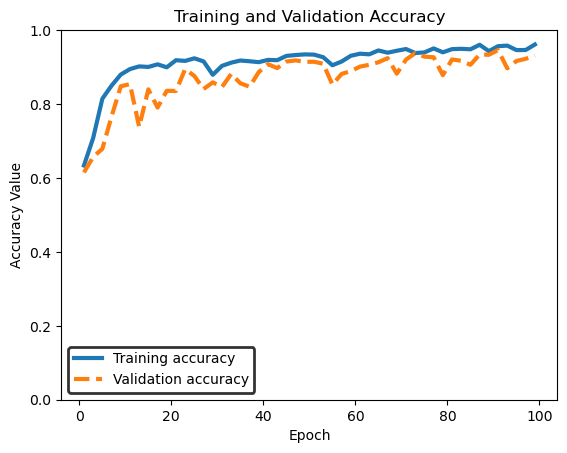

In [40]:
epoch_array = np.array(model_history.epoch)[1::2]
accuracy_array = np.array(model_history.history["accuracy"])[1::2]
validation_accuracy_array = np.array(model_history.history["val_accuracy"])[1::2]

fig, ax = plt.subplots()
ax.plot(epoch_array, accuracy_array, ls="-", c="C0", lw=3, label="Training accuracy")
ax.plot(epoch_array, validation_accuracy_array, ls="--", c="C1", lw=3, label="Validation accuracy")
ax.set_title("Training and Validation Accuracy")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy Value")
ax.set_ylim([0, 1])
leg = ax.legend()
leg.get_frame().set_edgecolor("k")
leg.get_frame().set_linewidth(2)
plt.savefig(plot_dir / "depth_temp_accuracy.png")

Save the trained model (in two alternative formats), so that it can be used without the need to rerun the training.

In [41]:
model.save(trained_nn_dir / "depth_temp.keras")
model.save(trained_nn_dir / "depth_temp.h5")

# Use trained model to make predictions

In this section we briefly show how to use the trained Neural Networks models.<br>
This section can be run without the section above, as the models have been pre-trained and saved to Google Drive.<br>
If the section above has already been run, then the one saved on Google Drive is not necessary.

In [42]:
zip_file_path = trained_nn_dir / "pretrained_models.zip"

# download the zip from Google Drive
gdown.download(id=os.environ["AMERY_TRAINED_NNS_GDRIVE_ID"], output=zip_file_path.as_posix())
# unzip the compressed file
with zipfile.ZipFile(zip_file_path, "r") as zip_content:
    zip_content.extractall(trained_nn_dir / zip_file_path.stem)
# remove the compressed file
zip_file_path.unlink()

Downloading...
From (original): https://drive.google.com/uc?id=1SolYfl2oG2meMi6RtcsZq7gaS9MHI0SD
From (redirected): https://drive.google.com/uc?id=1SolYfl2oG2meMi6RtcsZq7gaS9MHI0SD&confirm=t&uuid=9ca88d5d-5b30-439b-b7d8-8590b9f772dc
To: /home/alicebalfanz/deepesdl-doc/notebooks/science-cases/polar-science/trained_nn/pretrained_models.zip
100%|██████████| 177M/177M [00:02<00:00, 62.4MB/s] 


In [43]:
reconstructed_model = keras.models.load_model(
    trained_nn_dir / zip_file_path.stem / "depth_temp.keras")

Apply it to some imagery data that was not used during the training phase. This allows for example to infer an ice damage model for a different time period.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


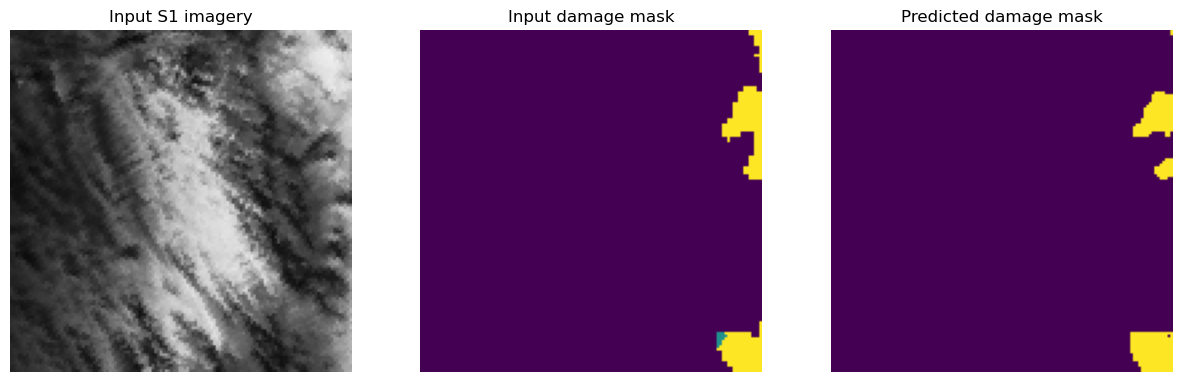

In [44]:
for image, mask in test_batches.take(1):
    index = int(np.random.rand() * len(image))
    pred_mask = reconstructed_model.predict(image[index][tf.newaxis, ...])
    show_imagery_and_damage([image[index], mask[index], create_mask(pred_mask)])